In [1]:
import pandas as pd
import numpy as np
import pickle
from google.colab import drive
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve

In [2]:
drive.mount('/drive')
uploaded = '/drive/My Drive/CS286/286Project/processed_data.pkl' #normal copy data
#uploaded = '/drive/My Drive/CS286/286Project/processed_data(max_copy_number).pkl' #Max copy data

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [3]:
with open(uploaded, 'rb') as f:
    loaded_dict = pickle.load(f)

print(loaded_dict.keys())
#print(loaded_dict['copy_number_matrix'].shape, '\n', loaded_dict['copy_number_matrix'])
#print(len(loaded_dict['labels']), '\n', loaded_dict['labels'])
#print(len(loaded_dict['patient_ids']), '\n', loaded_dict['patient_ids'])
#print(len(loaded_dict['gene_ids']),'\n', loaded_dict['gene_ids'])

dict_keys(['copy_number_matrix', 'patient_ids', 'labels', 'gene_ids'])


In [4]:
X_copy_number = loaded_dict['copy_number_matrix']
y_label = loaded_dict['labels']
#gene_ids = loaded_dict['gene_ids']
#print(X_copy_number)

In [5]:
# training 80%, testing 20%
X_train, X_test, y_train, y_test = train_test_split(X_copy_number, 
                                                    y_label, 
                                                    test_size = 0.20, 
                                                    random_state=40)

print(X_train.shape, X_test.shape)

(846, 60623) (212, 60623)


In [6]:
from sklearn.model_selection import GridSearchCV
'''
mlp_params = {
    'learning_rate': ["constant", "adaptive"],
    'hidden_layer_sizes': [(10,10,)],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'activation': ["relu", "logistic", "tanh"],
}'''

#Fitting the Multi-layer perceptron classifier
mlp = MLPClassifier(activation="logistic", hidden_layer_sizes=(10,10,), solver='sgd', learning_rate="adaptive", max_iter=1000)

#Running of GridSearchCV
'''gridMLP = GridSearchCV(estimator=mlp, param_grid=mlp_params, scoring='accuracy', verbose=10)
gridMLP.fit(X_train, y_train)
print('Best parameters found:', gridMLP.best_params_)
print('Best score:', gridMLP.best_score_)
y_pred = gridMLP.predict(X_test)'''
history = mlp.fit(X_train, y_train)


Classification report 

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       105
           1       0.95      0.93      0.94       107

    accuracy                           0.94       212
   macro avg       0.94      0.94      0.94       212
weighted avg       0.94      0.94      0.94       212

Accuracy: 93.89999999999999%


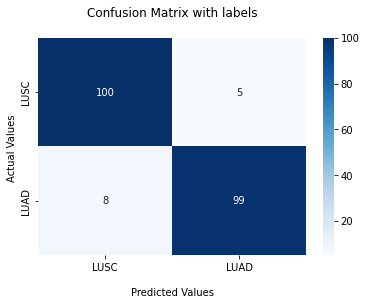

In [7]:
import seaborn as sns 
y_pred = mlp.predict(X_test)

#Print classification report
print("Classification report \n")
print(classification_report(y_test, y_pred))
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {0}%".format(100 * round(accuracy, 3)))

#print("Confusion Matrix")
#print(confusion_matrix(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')

ax.set_title('Confusion Matrix with labels\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['LUSC','LUAD'])
ax.yaxis.set_ticklabels(['LUSC','LUAD'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [8]:
#Generate a no skill prediction
ns_prob = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, threshold = roc_curve(y_test, ns_prob)

#Predict probabilities
probs = mlp.predict_proba(X_test)
probs = probs[:, 1]
#print(probs)
mlp_auc = roc_auc_score(y_test, probs)
print("ROC AUC for MLP:", round(mlp_auc, 2))

#Calculate thr ROC Curve
fpr, tpr, threshold = roc_curve(y_test, probs)
#print(len(fpr), len(tpr), threshold)

#Calculate the PR-curve
#pr_no_skill = len(y_test[y_test == 1]) / len(y_test)
prec, recall, _ = precision_recall_curve(y_test, probs)

ROC AUC for MLP: 0.97


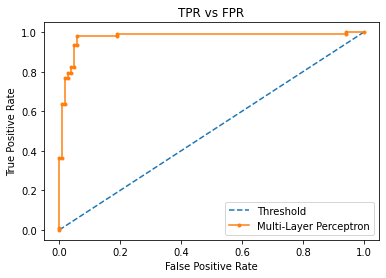

In [9]:
#Show the FPR vs TPR plots 
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Threshold')
plt.plot(fpr, tpr, marker='.', label='Multi-Layer Perceptron')
plt.title('TPR vs FPR')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

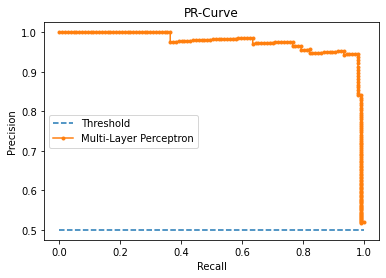

In [10]:
#Show the PR plots 
plt.plot([0, 1], [0.5, 0.5], linestyle='--', label='Threshold')
plt.plot(recall, prec, marker='.', label='Multi-Layer Perceptron')
plt.title('PR-Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()